In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data
data = pd.read_csv("/content/drive/MyDrive/code/train.csv")

# Convert the date column to datetime format
data['일시'] = pd.to_datetime(data['일시'], format='%Y%m%d')

# Set the date column as the index
data.set_index('일시', inplace=True)

#Rename the column names
data.index.names = ['Date']
data.columns = ["Gwang","Dong",'Sung',"Joong"] #광진구	동대문구	성동구	중랑구

print(data)

            Gwang   Dong   Sung  Joong
Date                                  
2018-01-01  0.592  0.368  0.580  0.162
2018-01-02  0.840  0.614  1.034  0.260
2018-01-03  0.828  0.576  0.952  0.288
2018-01-04  0.792  0.542  0.914  0.292
2018-01-05  0.818  0.602  0.994  0.308
...           ...    ...    ...    ...
2021-12-27  3.830  3.416  2.908  2.350
2021-12-28  4.510  3.890  3.714  2.700
2021-12-29  4.490  3.524  3.660  2.524
2021-12-30  4.444  3.574  3.530  2.506
2021-12-31  3.616  3.210  2.620  2.146

[1461 rows x 4 columns]


In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data)

[[0.03898841 0.0314315  0.04339369 0.02017937]
 [0.05532139 0.05244277 0.07736047 0.03238665]
 [0.05453109 0.04919713 0.0712255  0.03587444]
 ...
 [0.29570601 0.30099078 0.27382912 0.3143996 ]
 [0.2926765  0.30526136 0.26410295 0.31215745]
 [0.23814542 0.27417151 0.19601975 0.2673144 ]]


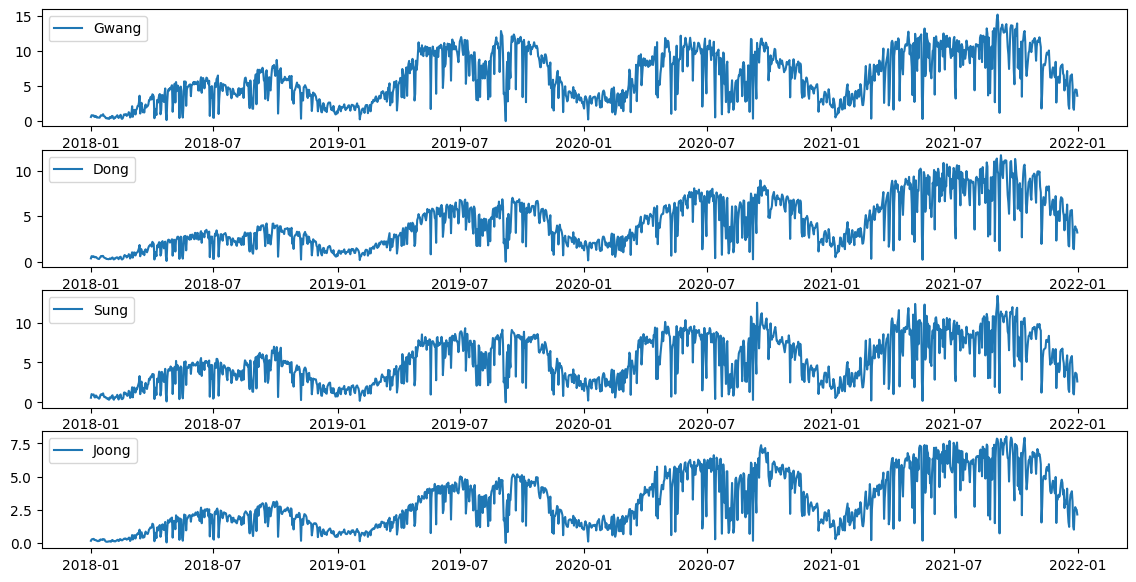

In [ ]:
# Plot the data to visualize the time series
plt.figure(figsize=(14, 7))
for i, col in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i+1)
    plt.plot(data.index, data[col], label=col)
    plt.legend(loc='upper left')
plt.show()

In [ ]:
# Transform the time series data into a suitable format for training the LSTM model
def create_sequences(data, seq_length):
    x_seq, y_seq = [], []
    for i in range(len(data) - seq_length): # range is 1 to len(data) - seq_length
        x = data[i:i+seq_length] # x becomes the data from 1 to seq_length + 1
        y = data[i+seq_length]
        #print('-->', y)
        x_seq.append(x)
        y_seq.append(y)
    return np.array(x_seq), np.array(y_seq) #returns array of x_seq and y_seq

In [ ]:
# Split the data into training and testing sets
split_ratio = 0.8
train_size = int(len(scaled_data) * split_ratio)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [ ]:
# Define sequence length
seq_length = 30

# Create sequences
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display the shapes of the datasets
print(f'{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_test.shape}')

torch.Size([1138, 30, 4]), torch.Size([1138, 4]), torch.Size([263, 30, 4]), torch.Size([263, 4])


Review this part!

In [ ]:
# Define the LSTM model (Extension of RNN)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # RNN으로 하고 싶으시면, 이 line지우시면 됩니다.
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Set device, hyperparameters, and initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
device = 'cpu'

cuda is available


In [ ]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [ ]:
input_size = X_train.shape[2] #4
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1] #4
num_epochs = 300
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_graph = []

In [ ]:
# Train the model
model.train() # Set the model to training mode
for epoch in range(num_epochs):
  running_loss = 0.0 # Initialize running loss for the current epoch
  for input in train_loader:
    optimizer.zero_grad() # Clear the gradients of all optimized tensors
    seq, target = input
    out = model(seq)
    loss = criterion(out, target)
    loss.backward() # compute gradient of the loss with respect to model parameters
    optimizer.step()  #Perform a single optimization step
    running_loss += loss.item()
  loss_graph.append(running_loss / len(train_loader))
  if (epoch + 1) % 10 == 0: # Print the loss every 10 epochs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') # Print the current epoch and loss

Epoch [10/300], Loss: 0.0151
Epoch [20/300], Loss: 0.0153
Epoch [30/300], Loss: 0.0152
Epoch [40/300], Loss: 0.0143
Epoch [50/300], Loss: 0.0137
Epoch [60/300], Loss: 0.0137
Epoch [70/300], Loss: 0.0135
Epoch [80/300], Loss: 0.0120
Epoch [90/300], Loss: 0.0134
Epoch [100/300], Loss: 0.0105
Epoch [110/300], Loss: 0.0100
Epoch [120/300], Loss: 0.0094
Epoch [130/300], Loss: 0.0086
Epoch [140/300], Loss: 0.0086
Epoch [150/300], Loss: 0.0116
Epoch [160/300], Loss: 0.0143
Epoch [170/300], Loss: 0.0073
Epoch [180/300], Loss: 0.0068
Epoch [190/300], Loss: 0.0069
Epoch [200/300], Loss: 0.0056
Epoch [210/300], Loss: 0.0054
Epoch [220/300], Loss: 0.0064
Epoch [230/300], Loss: 0.0057
Epoch [240/300], Loss: 0.0037
Epoch [250/300], Loss: 0.0028
Epoch [260/300], Loss: 0.0021
Epoch [270/300], Loss: 0.0017
Epoch [280/300], Loss: 0.0023
Epoch [290/300], Loss: 0.0013
Epoch [300/300], Loss: 0.0009


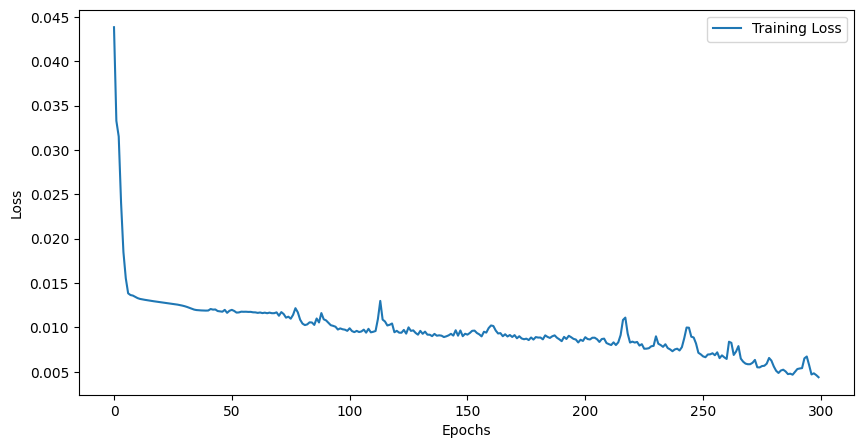

In [ ]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), loss_graph, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From here review

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    train_predictions = model(X_train.to(device)).cpu().numpy()
    test_predictions = model(X_test.to(device)).cpu().numpy()

In [ ]:
# Inverse transform the predictions and true values
train_predictions = scaler.inverse_transform(train_predictions)
print(y_train)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)
print(y_train)

tensor([[0.0312, 0.0289, 0.0447, 0.0125],
        [0.0478, 0.0367, 0.0611, 0.0252],
        [0.0482, 0.0401, 0.0663, 0.0279],
        ...,
        [0.4963, 0.5031, 0.4872, 0.5264],
        [0.4344, 0.4636, 0.4193, 0.4467],
        [0.5693, 0.5104, 0.5890, 0.5486]])
[[0.474      0.33800001 0.598      0.1       ]
 [0.72599998 0.43000002 0.816      0.202     ]
 [0.73199997 0.46999998 0.88599996 0.224     ]
 ...
 [7.53599994 5.89000005 6.51199994 4.22600021]
 [6.59600007 5.42799989 5.60399998 3.58599999]
 [8.64400044 5.97599974 7.87200022 4.40400017]]


In [ ]:
# Calculate RMSE Lower the RMSE, the lower, the better
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

In [ ]:
# Calculate NMAPE: the lower, the better
def nmape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (np.max(y_true) - np.min(y_true)))) * 100
train_nmape = nmape(y_train, train_predictions)
test_nmape = nmape(y_test, test_predictions)

print(f'Train RMSE: {train_rmse:.4f}, Train NMAPE: {train_nmape}')
print(f'Test RMSE: {test_rmse:.4f}, Test NMAPE: {test_nmape}')

Train RMSE: 4.5275, Train NMAPE: 29.256730210118466
Test RMSE: 7.5050, Test NMAPE: 46.31083830563041


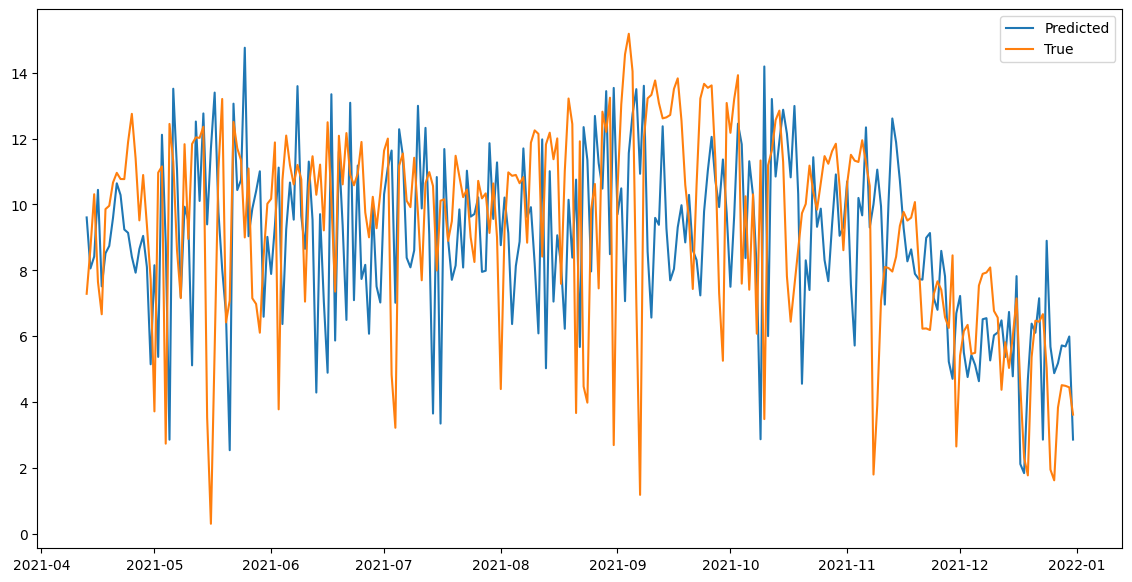

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(test_predictions):], test_predictions[:, 0], label='Predicted')
plt.plot(data.index[-len(test_predictions):], y_test[:, 0], label='True')
plt.legend()
plt.show()

In [ ]:
# Forecasting future values
future_steps = 30  # Number of days to forecast
last_sequence = X_test[-1].unsqueeze(0).to(device)
future_predictions = []

In [ ]:
# Model prediction
model.eval()
for _ in range(future_steps):
    with torch.no_grad():
        future_pred = model(last_sequence)
        future_predictions.append(future_pred.cpu().numpy())
        # Update last_sequence by removing the first time step and adding the new prediction
        last_sequence = torch.cat((last_sequence[:, 1:, :], future_pred.unsqueeze(1)), dim=1)

future_predictions = np.array(future_predictions).reshape(-1, output_size)
future_predictions = scaler.inverse_transform(future_predictions)

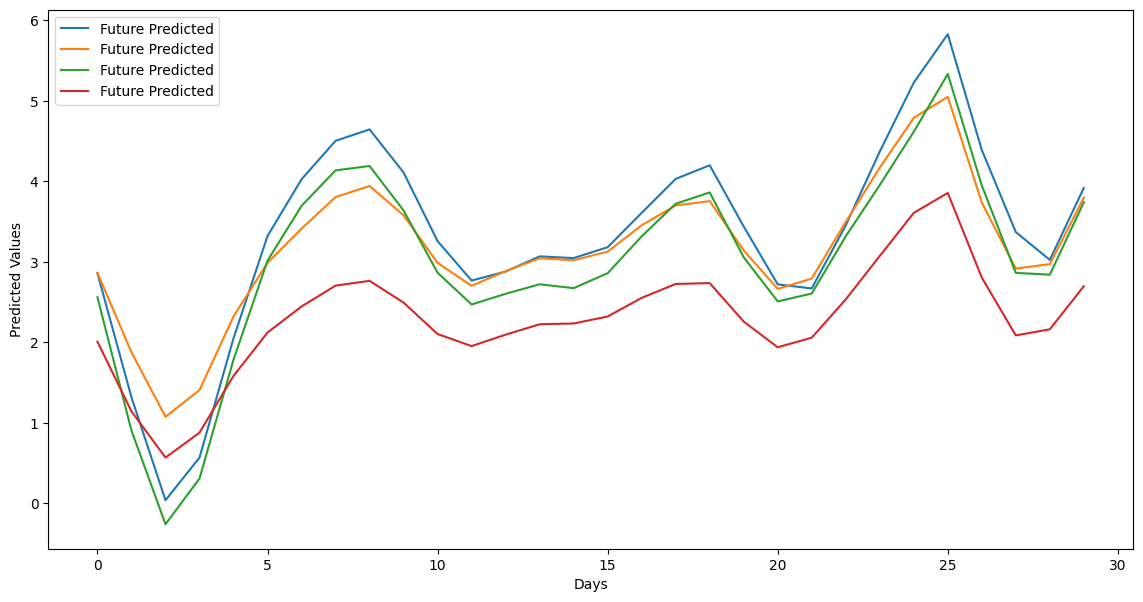

In [ ]:
# Plot the future predictionsdd
plt.figure(figsize=(14, 7))
plt.plot(range(future_steps), future_predictions[:, 0], label='Future Predicted')
plt.plot(range(future_steps), future_predictions[:, 1], label='Future Predicted')
plt.plot(range(future_steps), future_predictions[:, 2], label='Future Predicted')
plt.plot(range(future_steps), future_predictions[:, 3], label='Future Predicted')
plt.xlabel('Days')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Calculate the total rentals for the forecasted period
total_rentals = np.sum(future_predictions, axis=0)
print(f'Total rentals for the next {future_steps} days: {total_rentals}')
print(f'Rental average for the next {future_steps} days: {total_rentals / future_steps}')

Total rentals for the next 30 days: [99.89562 95.47626 89.85442 68.72415]
Rental average for the next 30 days: [3.329854  3.1825418 2.9951475 2.290805 ]
